# Project Goals
## Overview
## The Problem: Finding a Needle in a Haystack

> Elevator Pitch / What we want to accomplish

# The Data: First Look

Let's get our data into a dataframe to examin it:

In [1]:
import src.wrangle
import src.preprocessing
import src.features
import src.model

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

df = src.wrangle.get_raw_data()
data_dict = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')

df.head()

,encounter_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
patient_id,,,,,,,,,,,,,,,,,,,,,
25312,66154,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
59342,114252,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
50777,119783,118,0,25.0,31.95,0,Caucasian,F,172.7,Emergency Department,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
46918,79267,118,0,81.0,22.64,1,Caucasian,F,165.1,Operating Room,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
34377,92056,33,0,19.0,NaN,0,Caucasian,M,188.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


## Size of the Raw Data

In [2]:
print(f'''Number of Columns: {df.shape[1]}, Number of Rows: {df.shape[0]}''')

Number of Columns: 185, Number of Rows: 91713


> This means that we have *91,713* patients in our dataset, with *185* metrics recorded for each of them within that 24 hour period. That's quite a bit of data.

## Number of Hospitals

In [3]:
print(f'Number of hospitals: {df.hospital_id.nunique()}')

Number of hospitals: 147


## Imbalanced Data

Our goal for this project is to predict patient survivability, so what does that distribution look like in our data?

In [4]:
num_patients_died = len(df[df.hospital_death == 1])
print('Percentage of patients who did not survive: {: .2f}'.format(num_patients_died / len(df)))

Percentage of patients who did not survive:  0.09


>*91* percent of the patients survived their time in the ICU, while only *9* percent did not. 

While this is great news in terms of ICU survival rates, it means we're dealing with an imbalanced dataset which is going to raise its own challenges as we move forward.

## Quick Look at the Missing Values

We'll be using a library called [missingno]('https://github.com/ResidentMario/missingno') to visualize the missing values within the data.

demographic


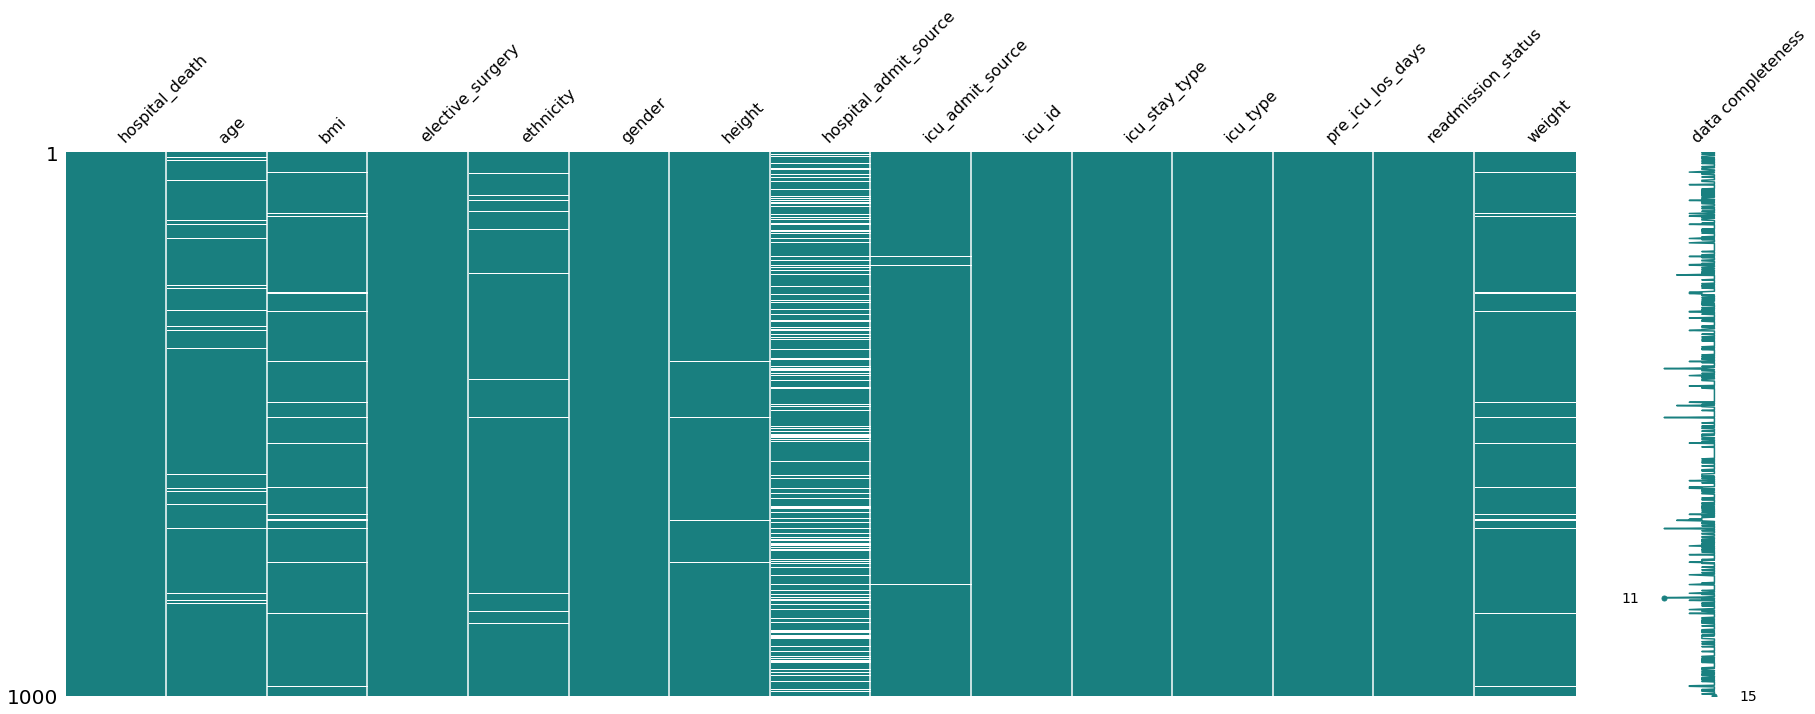

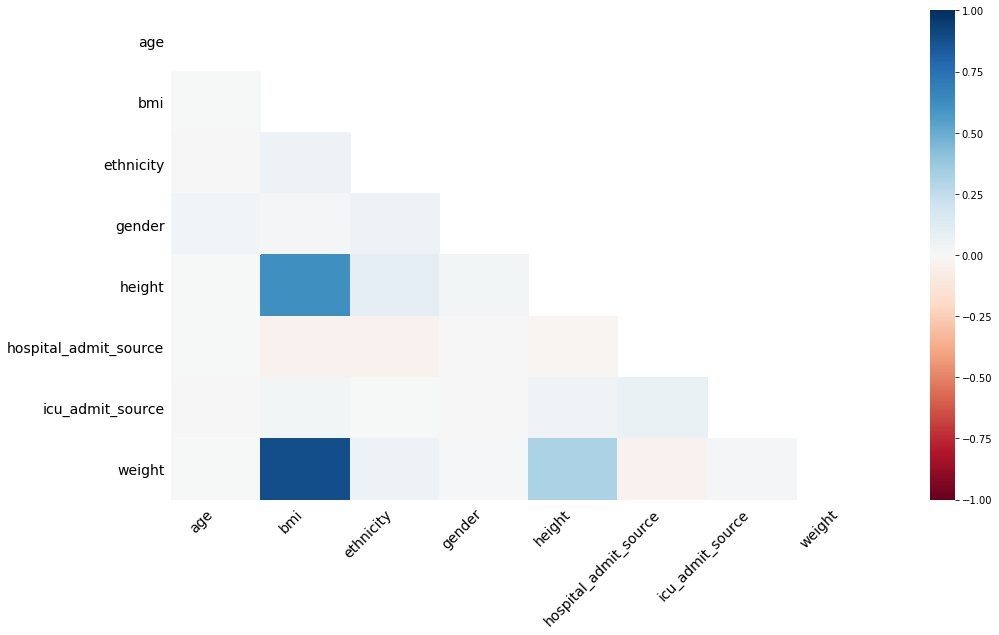

APACHE covariate


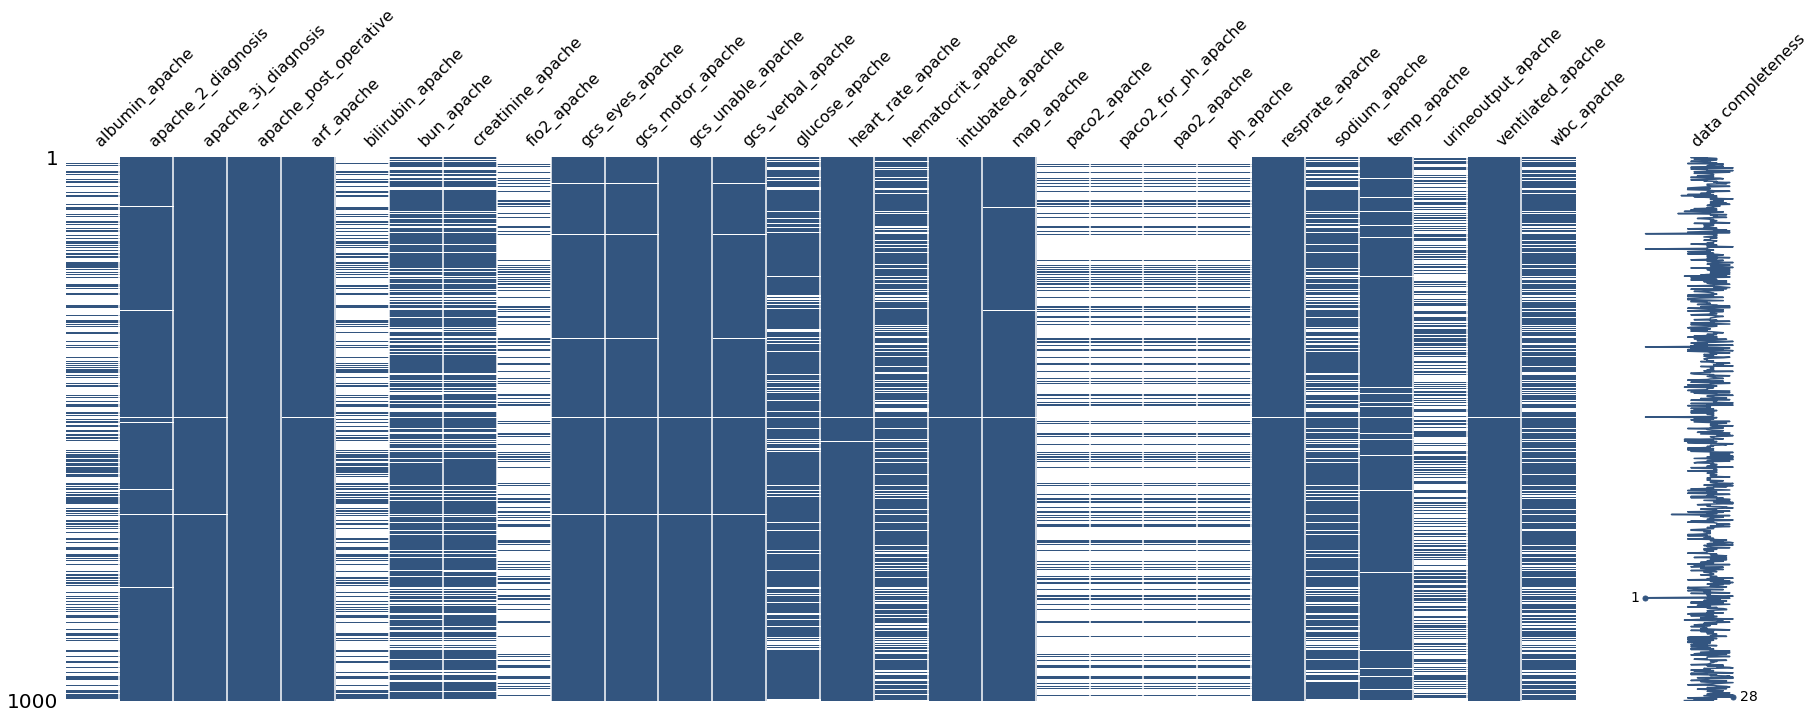

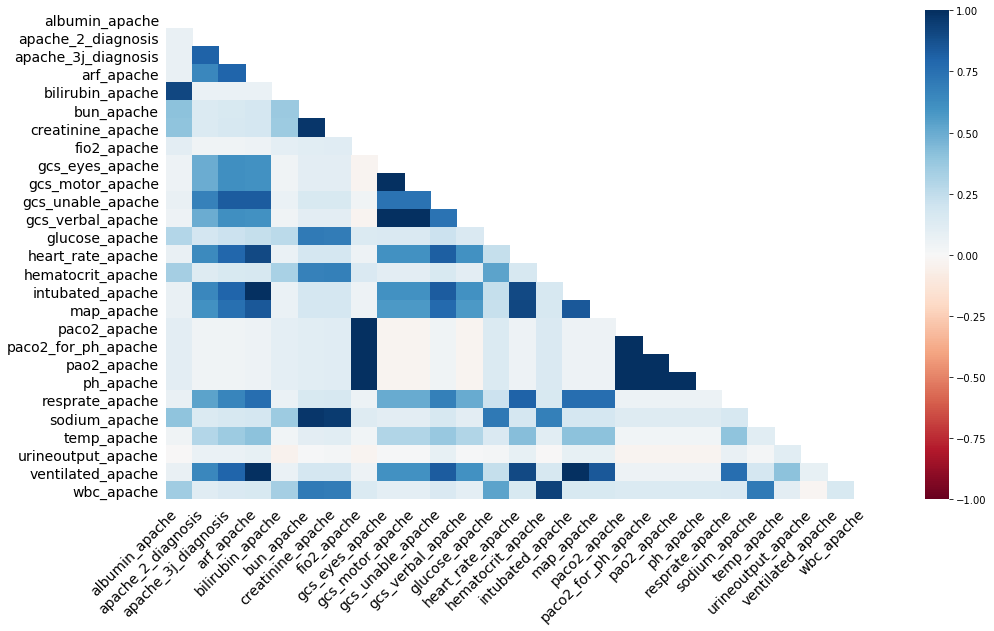

vitals


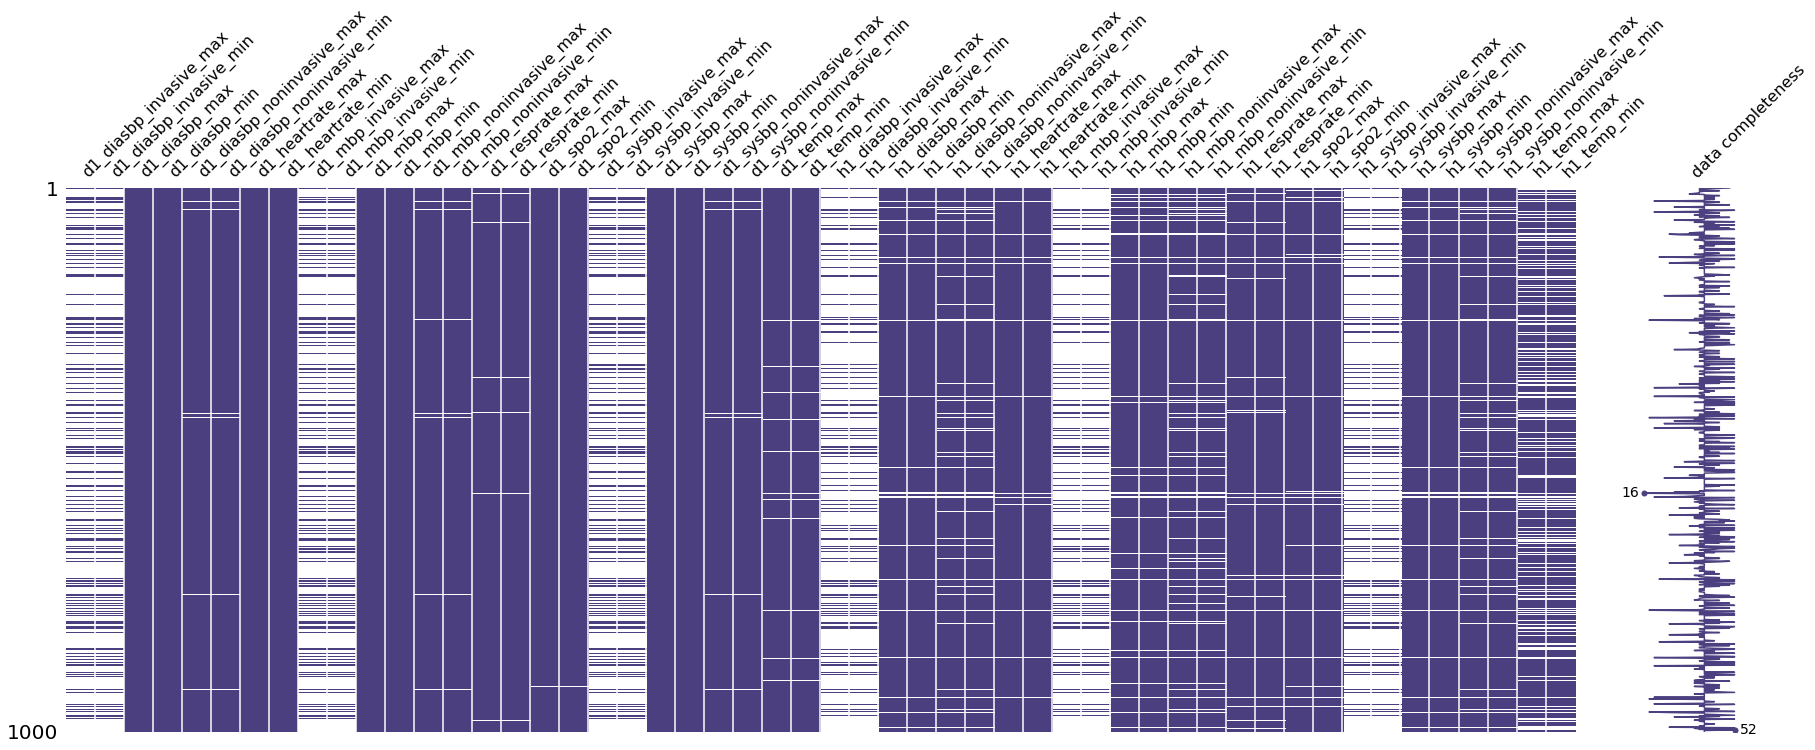

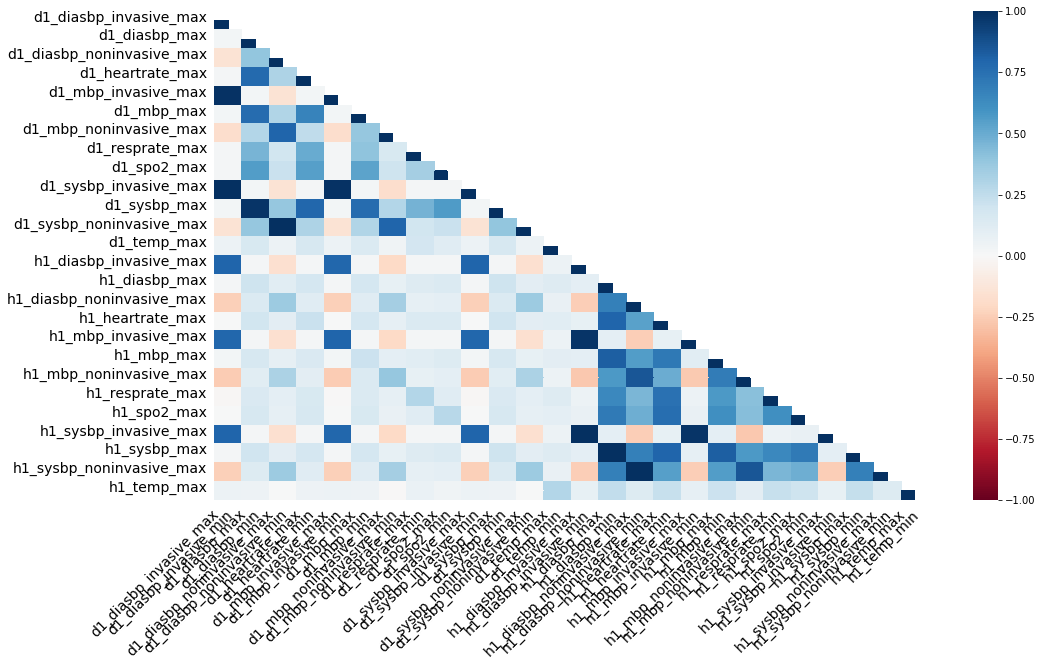

labs


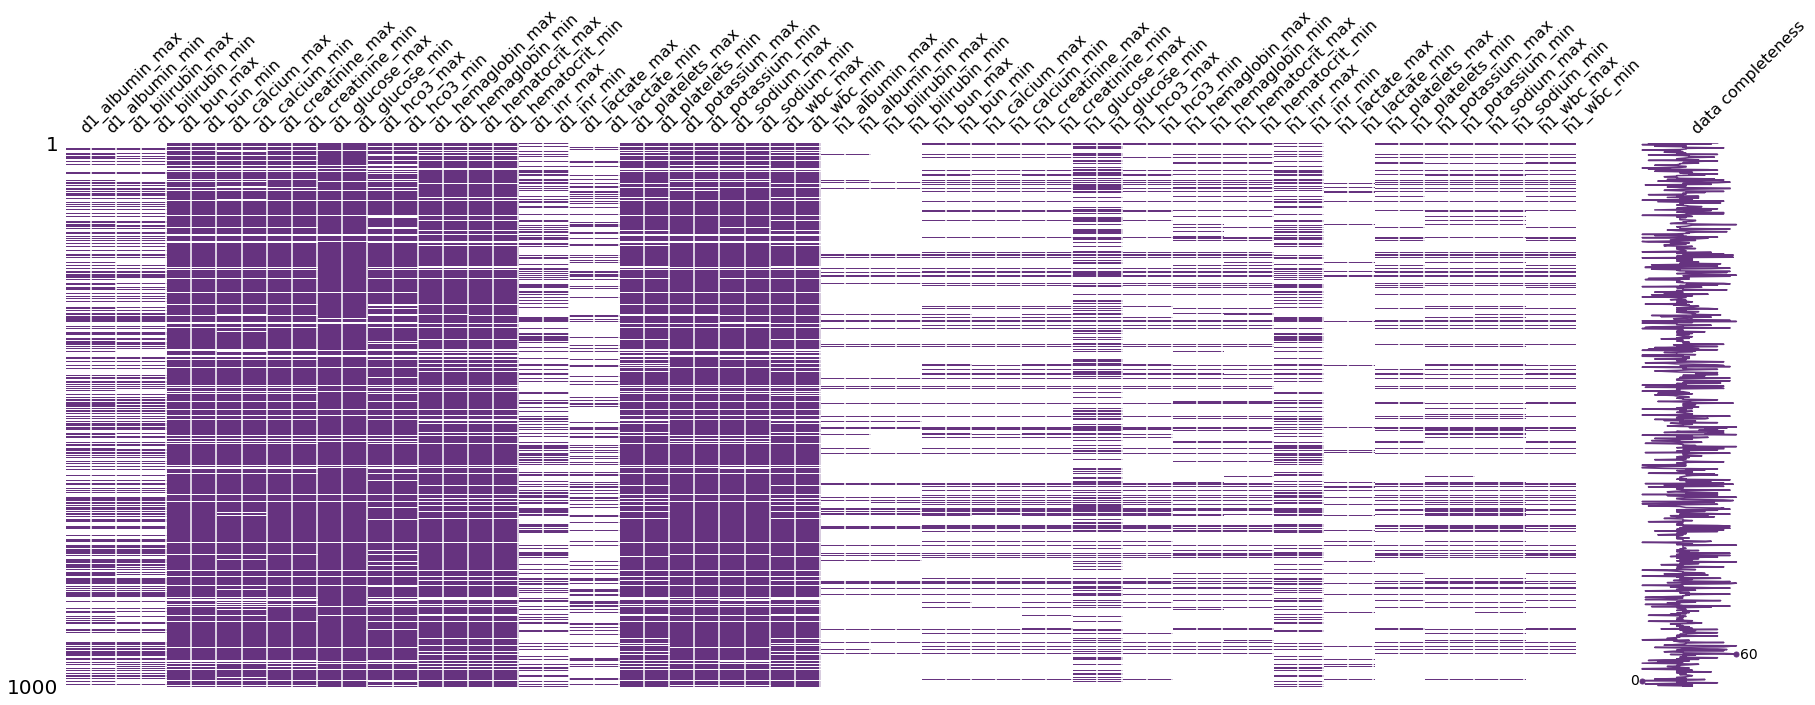

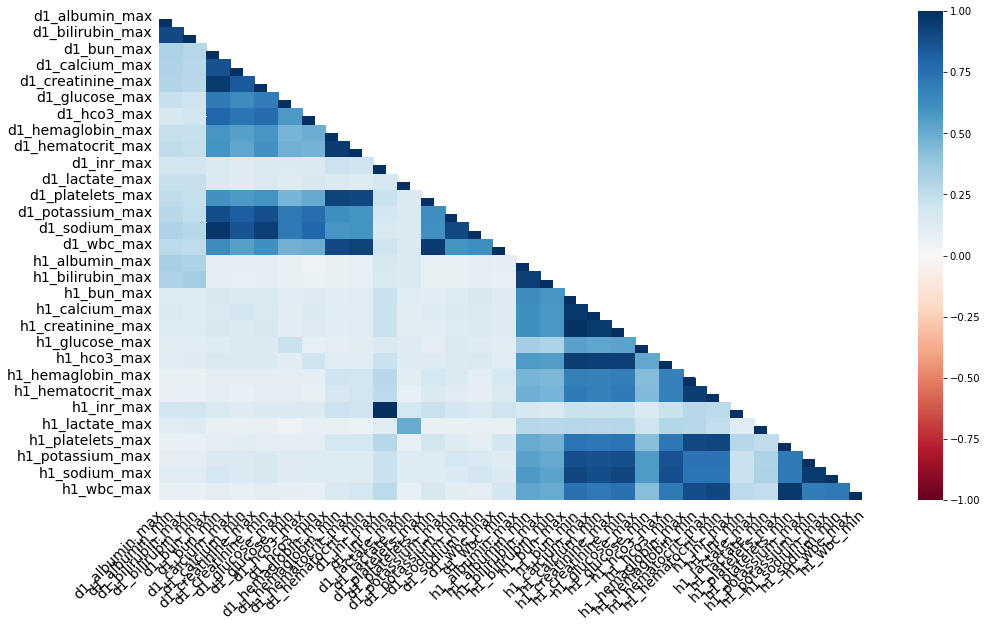

labs blood gas


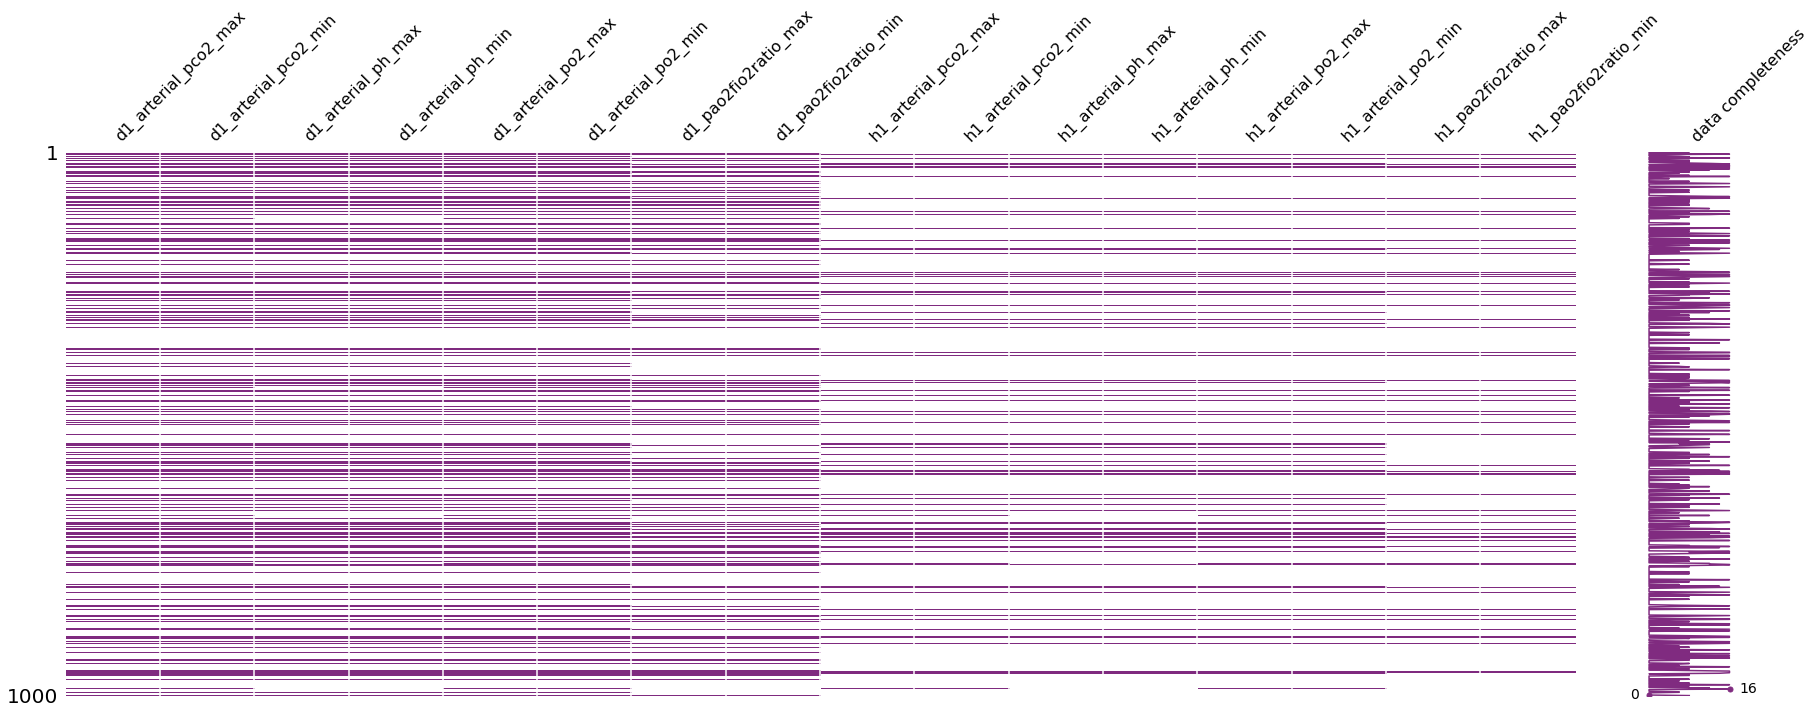

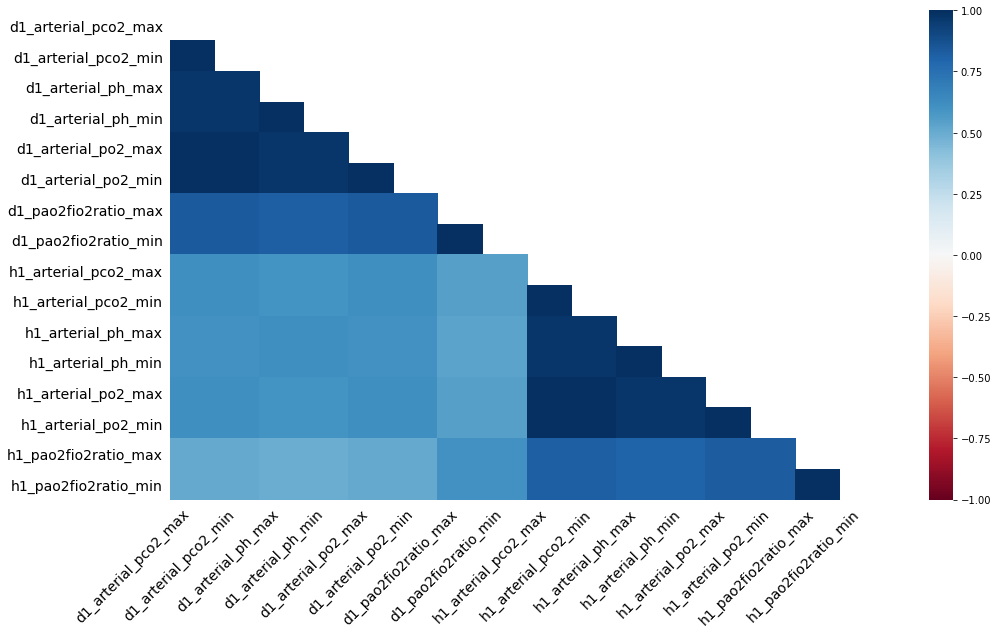

APACHE prediction


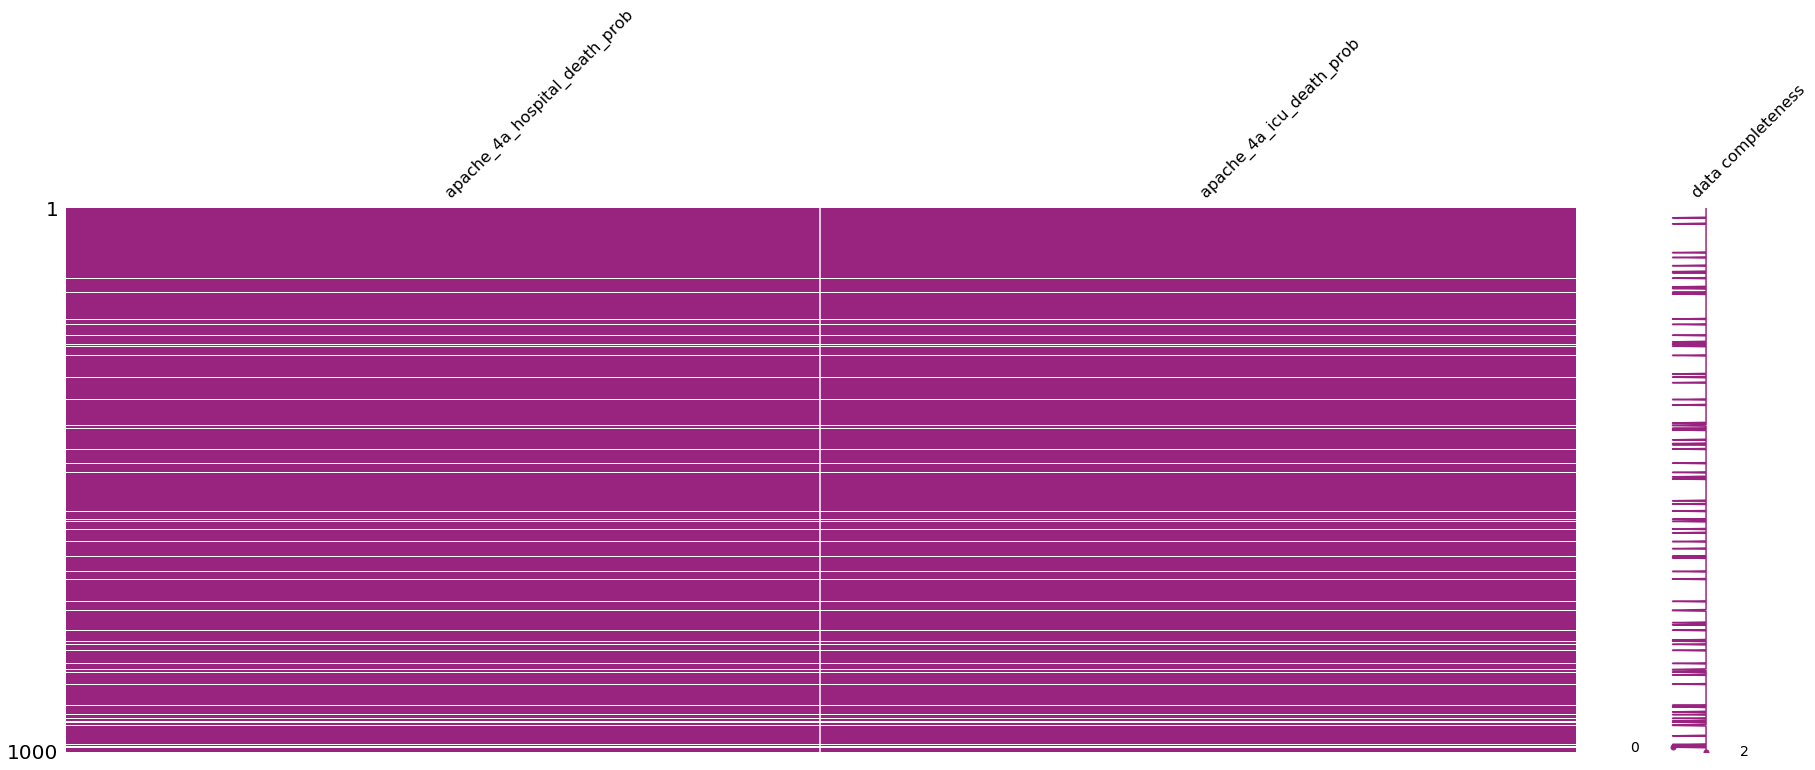

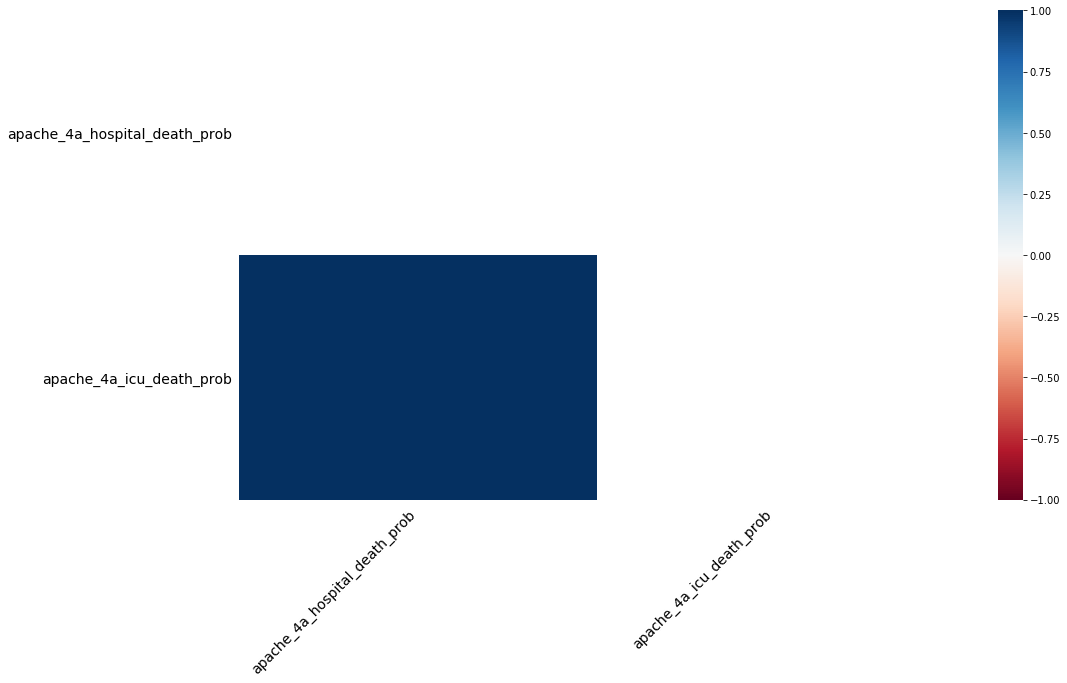

APACHE comorbidity


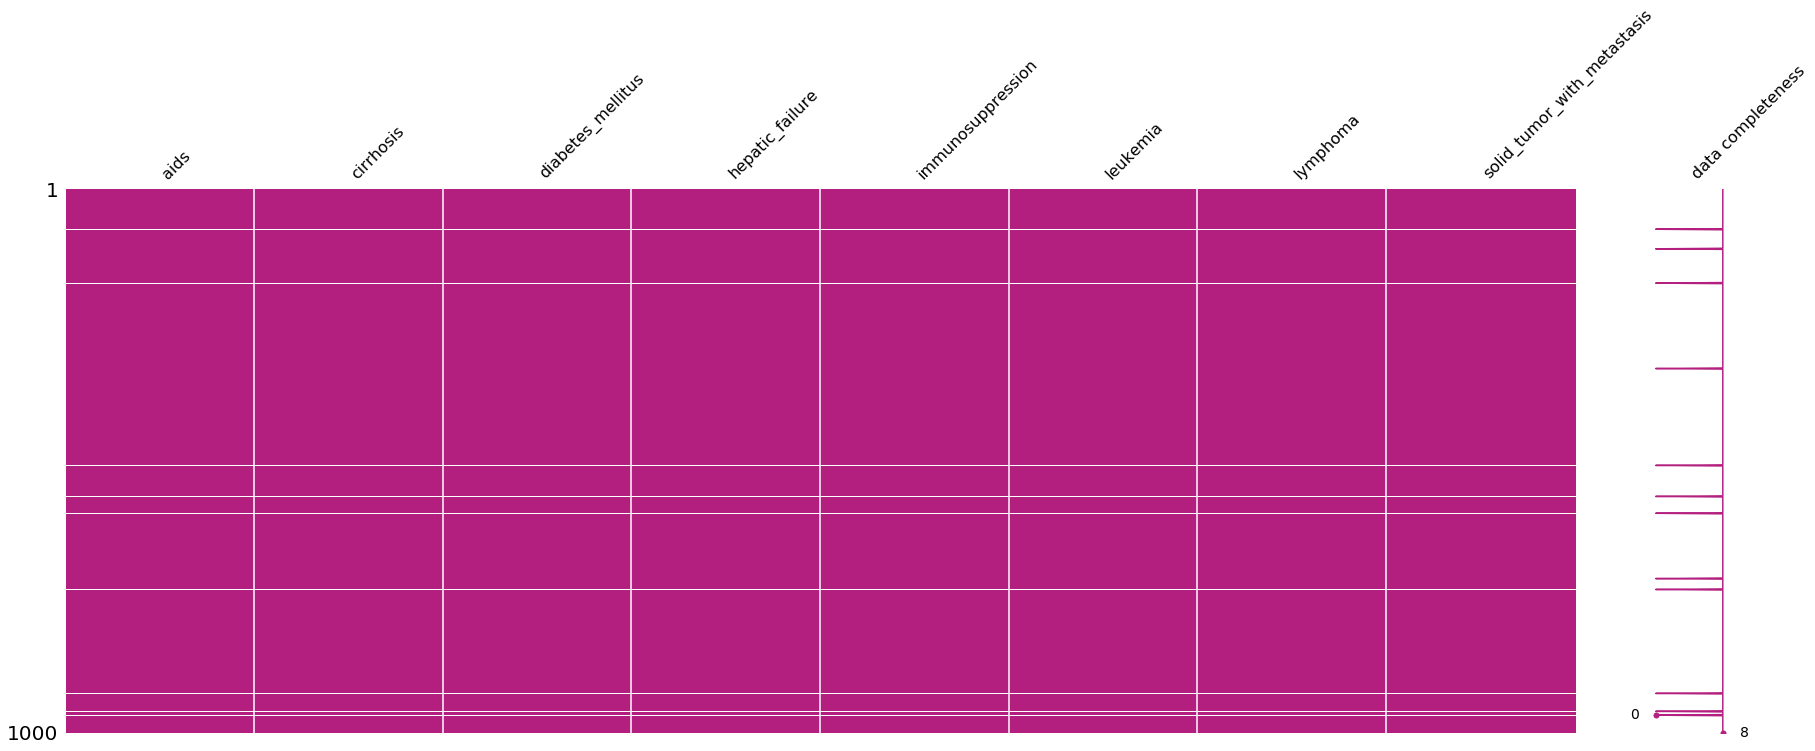

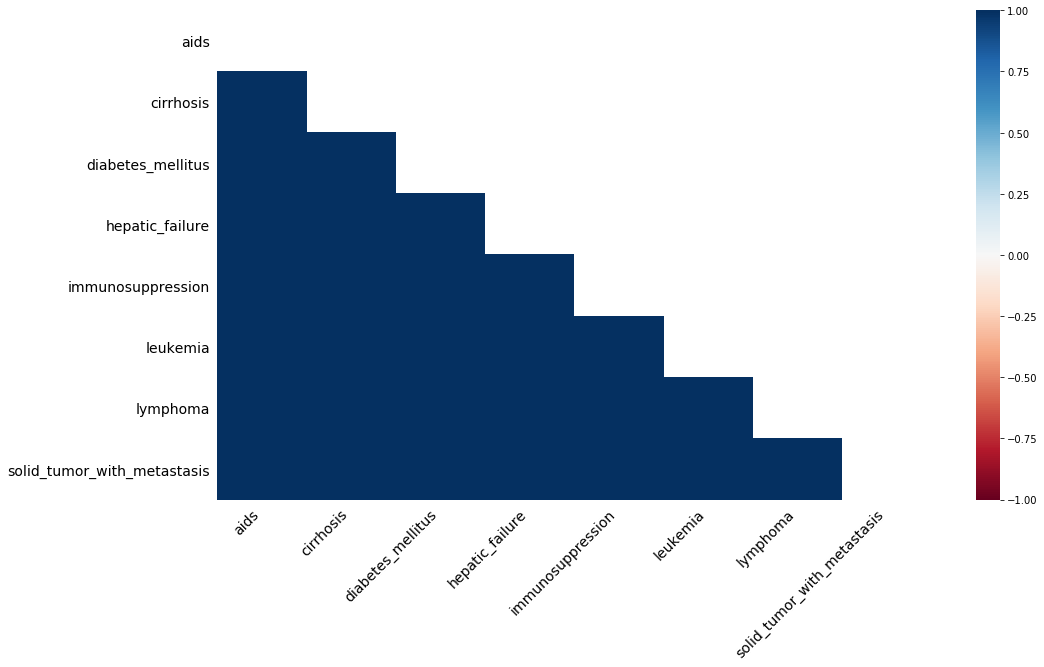

APACHE grouping


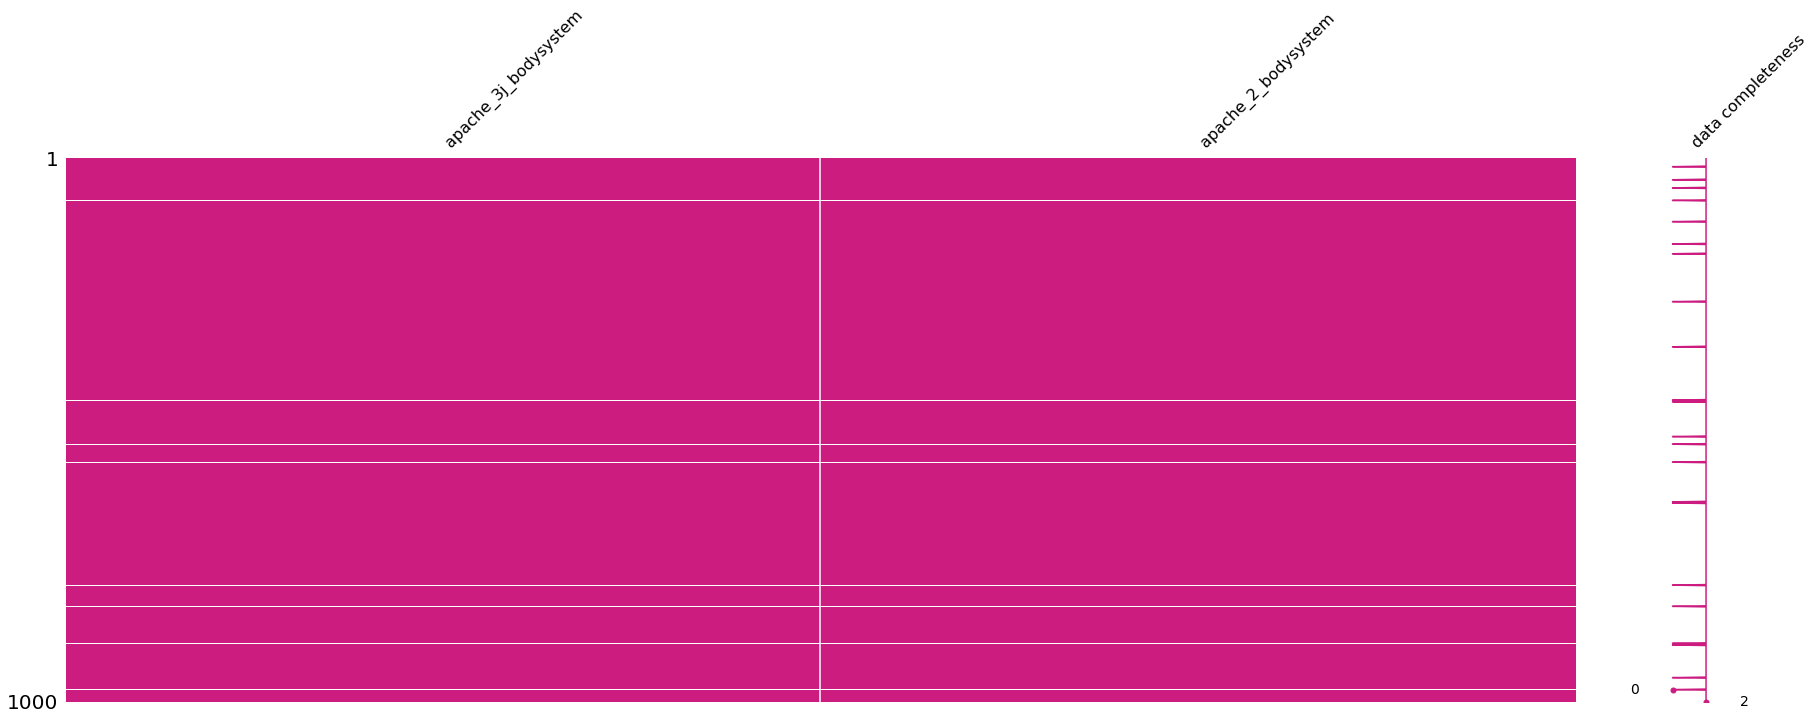

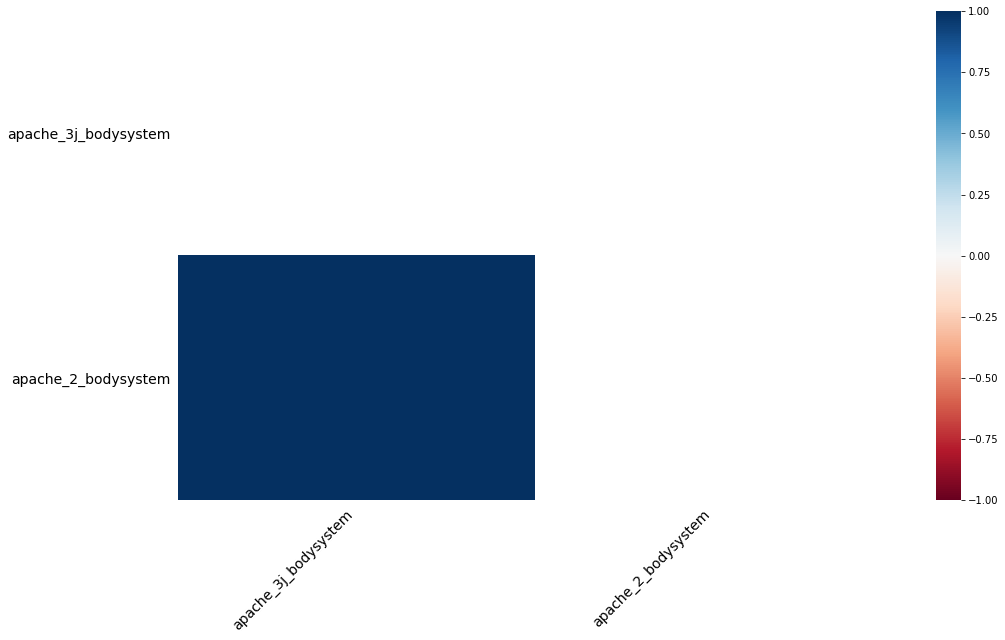

In [5]:
import missingno as msno
import matplotlib.pyplot as plt

for color, variable in enumerate(data_dict["Category"].unique()):
    if variable not in ["GOSSIS example prediction", "identifier"]:
        print(variable)
        column_list = data_dict[data_dict["Category"] == variable]["Variable Name"].values.tolist()
        column_list = [f for f in column_list if f in df.columns]
        if len(column_list) > 0:
            msno.matrix(
                df[column_list].sample(1000),
                figsize=(30, 10),
                labels=True,
                color=(color / 10, 1 / (color + 1), 0.5),
                fontsize=16,
            )
            msno.heatmap(
                df[column_list], figsize=(16, 9), labels=False, fontsize=14
            )
            plt.show()

# Preparation: Challenges Faced and How We Handled Them

## Null Values: A Different Beast in an Imbalanced Data Set
Since our target value (patient survivability) we're attempting to predict is imbalanced in our dataset, this affects our ability to handle nulls through blanket fixes. What we'll have to do is correlate the significance of the missing values against our target value to identify if the missing values are actually playing a role in patient survivability. 

In [6]:
import pandas as pd
from scipy import stats
# Set alpha value
alpha = 0.05

for col in df.columns:

    a, b = df[col], df["hospital_death"]

    observed = pd.crosstab(a, b) 
    chi2, p, degf, expected = stats.chi2_contingency(observed)

    if p < alpha:
        # Reject the null hypothesis
        print("({} and hospital_death) are  dependent of each other. (p = {})".format(col, p))
    else:
        # Failed to reject the null hypothesis
        print("({} and hospital_death) are  independent of each other. (p = {})".format(col, p))

(encounter_id and hospital_death) are  independent of each other. (p = 0.4984475106646044)
(hospital_id and hospital_death) are  dependent of each other. (p = 3.971188907548724e-148)
(hospital_death and hospital_death) are  dependent of each other. (p = 0.0)
(age and hospital_death) are  dependent of each other. (p = 4.3986226670688454e-204)
(bmi and hospital_death) are  independent of each other. (p = 0.10323036630688469)
(elective_surgery and hospital_death) are  dependent of each other. (p = 1.8111023373323387e-176)
(ethnicity and hospital_death) are  dependent of each other. (p = 0.0031164745025517304)
(gender and hospital_death) are  dependent of each other. (p = 0.03441709366041668)
(height and hospital_death) are  dependent of each other. (p = 0.0021710052871524873)
(hospital_admit_source and hospital_death) are  dependent of each other. (p = 1.2519350471326363e-197)
(icu_admit_source and hospital_death) are  dependent of each other. (p = 3.7031521455538844e-243)
(icu_id and hos

## Splitting the Data

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = df.drop(columns="hospital_death")
y = df.hospital_death
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42, stratify=y
)

## Applying Wrangle to the Split Data

In [9]:
for df in [X_train, X_test]:
    df.pipe(src.wrangle.prepare_data)

In [10]:
X_train.isna().sum().sum(), X_test.isna().sum().sum()

(0, 0)

In [11]:
y_train.isna().sum().sum(), y_test.isna().sum().sum()

(0, 0)

# Exploration: Examining Which Factors are Affecting Patient Survival

## Are certain hospitals better at data collection, and does that have an impact on patient outcomes?

## Is there a link between hospital and death rate?

## Does the age of the patient have a significant impact on patient survivability?

## The gender of the patient and outcome?

# Feature Engineering: 'Bringing a Magnet to the Needle in a Haystack Problem'

# Modeling: Bringing it All Together

## Encoding the Data

In [12]:
import src.preprocessing

In [13]:
X_train_cols_to_encode = [col for col in X_train.columns if X_train[col].dtype == object]
X_test_cols_to_encode = [col for col in X_test.columns if X_test[col].dtype == object]
X_train = src.preprocessing.encode(X_train, X_train_cols_to_encode)
X_test = src.preprocessing.encode(X_test, X_test_cols_to_encode)

In [14]:
X_train.head(1)

,encounter_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,...,apache_2_bodysystem_Cardiovascular,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses
patient_id,,,,,,,,,,,,,,,,,,,,,
57225,44014,176,72,32.04133,0,154.9,628,0.061111,0,76.88,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Applying Models

In [15]:
import src.model_eval
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
logit = LogisticRegression(C = 0.1, class_weight = ‘balanced’,penalty = ‘l2’, max_iter=1000)
logit.fit(X_train, y_train)

LogisticRegression(C=100.0, class_weight='balanced', max_iter=1000)

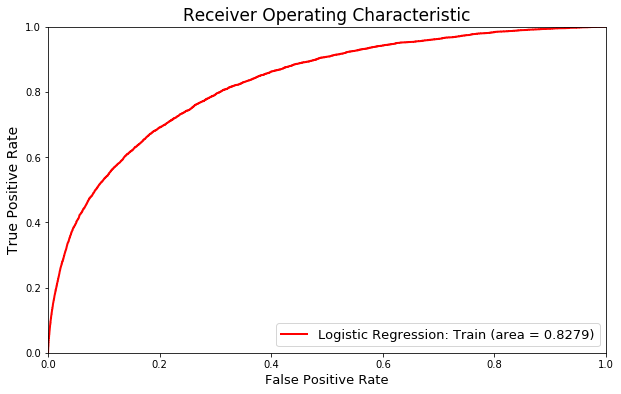

In [18]:
src.model_eval.evaluate_auc(logit, X_train, y_train, 'Logistic Regression: Train')

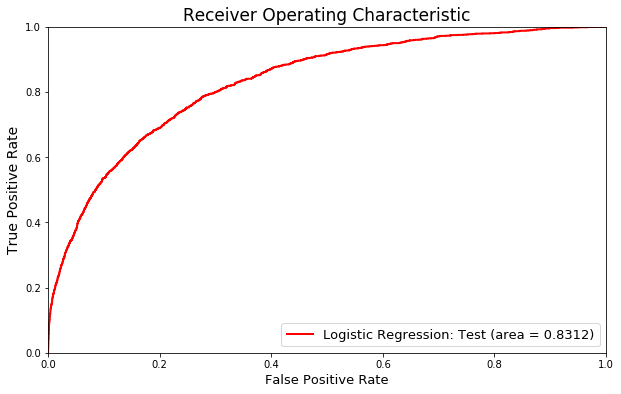

In [19]:
src.model_eval.evaluate_auc(logit, X_test, y_test, 'Logistic Regression: Test')

### Decision Tree

In [20]:
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

Results on the Training Data:

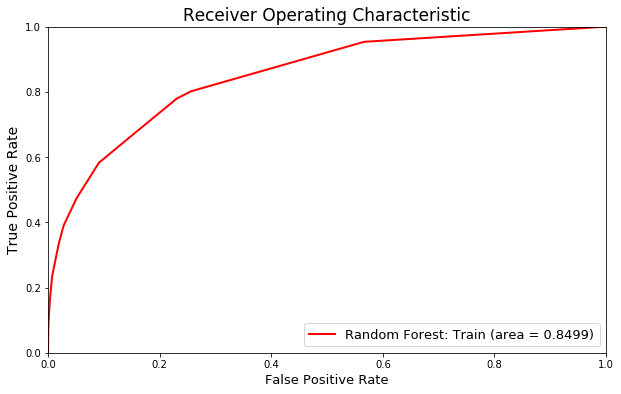

In [21]:
src.model_eval.evaluate_auc(tree, X_train, y_train, 'Decision Tree: Train')

Results on the Test Data:

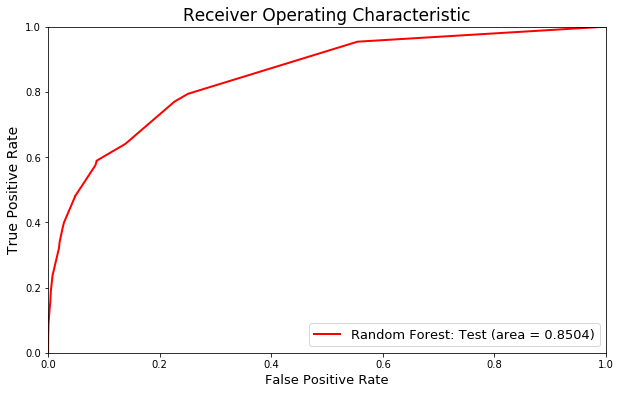

In [22]:
src.model_eval.evaluate_auc(tree, X_test, y_test, 'Decision Tree: Test')

**Identifying which features were the most impactful to the Decision Tree model:**

In [23]:
src.model.get_feature_importance(X, tree.feature_importances_)

,feature,importance
14,h1_arterial_ph_min,0.594082
13,h1_arterial_ph_max,0.159992
10,d1_hemaglobin_min,0.13022
3,d1_mbp_min,0.036145
1,d1_diasbp_invasive_min,0.0287705
4,d1_spo2_min,0.0135609
12,h1_sodium_max,0.00830863
9,d1_hemaglobin_max,0.00706927
0,urineoutput_apache,0.0050154
2,d1_diasbp_min,0.00475298


### XG Boost

In [28]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV

In [30]:
xgb = XGBClassifier(learning_rate =0.1, n_estimators=177, max_depth=7,
 min_child_weight=5, gamma=0.25, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, reg_alpha=0.0001, seed=27)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=177, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0.0001, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

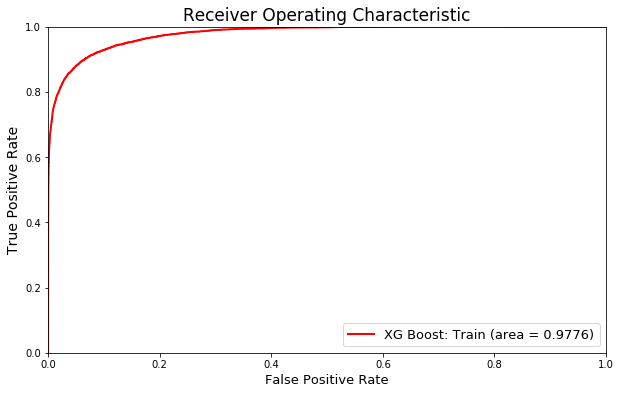

In [31]:
src.model_eval.evaluate_auc(xgb, X_train, y_train, 'XG Boost: Train')

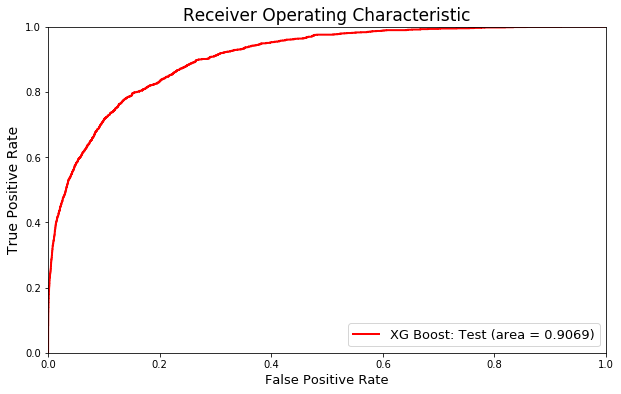

In [32]:
src.model_eval.evaluate_auc(xgb, X_test, y_test, 'XG Boost: Test')

### Light GBM

In [34]:
from lightgbm import LGBMClassifier

In [35]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 6
params['min_child_weight'] = 1
params['n_estimators'] = 350
clf = lgb.train(params, d_train, 350)

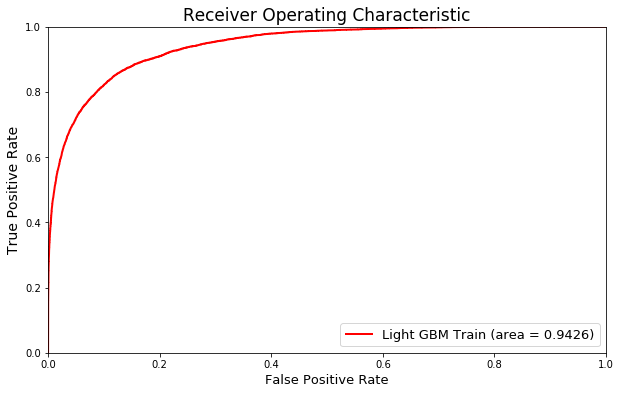

In [38]:
plt.figure(figsize=(10,6))

y_pred=clf.predict(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='Light GBM Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

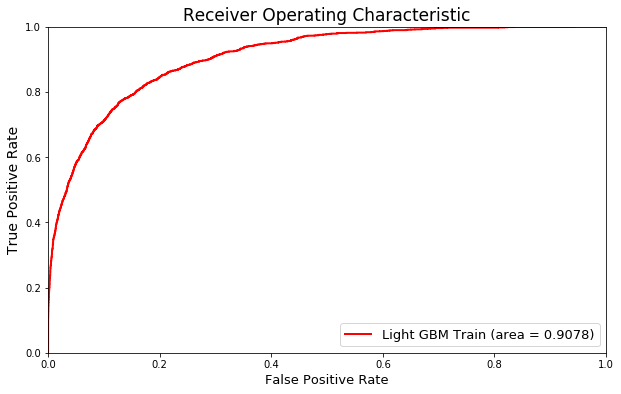

In [39]:
plt.figure(figsize=(10,6))

y_pred=clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='Light GBM Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

# Conclusion